<h1>Машинне навчання</h1>
<p>Ю.С. Процик. Курс лекцій</p>
<div align="right"><em>Cформовано на основі <a href="https://mlcourse.ai">відкритого курсу</a> Юрія Кашницького</em></div>

# <center> Тема 6. Ансамблі і випадковий ліс</center>
## <center> Частина 2. Оцінка важливості ознак</center>

## План

1. [Інтуїція](#1.-Інтуїція)
2. [Permutation Importance](#2.-Permutation-Importance)
3. [Важливість ознак в Sklearn Random Forest](#3.-Важливість-ознак-в-Sklearn-Random-Forest)
4. [Практичний приклад](#4.-Практичний-приклад)

Дуже часто виникає бажання зрозуміти свій алгоритм, чому він дав саме таку відповідь, а не іншу. Або якщо не зрозуміти його повністю, то хоча б з'ясувати, які ознаки більше впливають на результат. З випадкового лісу можна досить просто отримати дану інформацію.

## 1. Інтуїція

З рисунку нижче інтуїтивно зрозуміло, що важливість ознаки «Вік» в задачі кредитного скорингу більша, ніж важливість ознаки «Дохід». Формалізується це за допомогою поняття приросту інформації.

<img src="../img/credit_scoring_toy_tree_english.png" align='center'>

Якщо побудувати багато дерев рішень (випадковий ліс), то чим вище в середньому ознака в дереві рішень, тим вона важливіша в даній задачі класифікації/регресії. При кожному розбитті в кожному дереві поліпшення критерію розбиття (в нашому випадку невизначеність Джині (Gini impurity)) — це показник важливості, пов'язаний з ознакою розбиття. Він накопичується по всіх деревах лісу окремо для кожної ознаки.

Давайте трохи заглибимося в деталі.

Лео Брейнман у своїх роботах запропонував оцінити важливість ознаки, обчислюючи зниження точності лісу, коли значення ознаки переставляються випадковим чином, або зменшення невизначеності (неоднорідності) вузлів, де дана ознака використовується для розбиття. Перший метод часто називають **permutation importance (важливість перестановки)**, а останній застосовується в `sklearn`.

## 2. Permutation Importance

Щоб оцінити важливість ознаки, її значення перемішуються для всіх об'єктів навчальної вибірки. Важливість ознаки оцінюється шляхом усереднення по всіх деревах різниці показників out-of-bag-помилок до і після перемішування значень. При цьому значення таких помилок нормалізуються за стандартним відхиленням. Ознака вважається «важливою», якщо точність моделі падає і її зміна викликає збільшення кількості помилок. З іншого боку, ознака вважається «неважливою», якщо перемішування її значень не впливає на точність моделі.

Більш формально: через $\large \overline{\mathfrak{B}}^{(t)}$ позначимо оut-of-bag вибірку для дерева $\large t$, для $\large t\in\{1, ..., N\}$, де $\large N$ — це кількість дерев в ансамблі. Тоді *permutation importance* ознаки $\large X_j$ у дереві $\large t$ дорівнює

$$\large {PI}^{(t)}\left(X_j\right)=\frac{\sum\limits_{i\in\overline{\mathfrak{B}}^{(t)}}I\left(y_i=\hat{y}_i^{(t)}\right)}{\left|\overline{\mathfrak{B}}^{(t)}\right|}-\frac{\sum\limits_{i\in\overline{\mathfrak{B}}^{(t)}}I\left(y_i=\hat{y}_{i,\pi_j}^{(t)}\right)}{\left|\overline{\mathfrak{B}}^{(t)}\right|}$$

де $\large \hat{y}_i^{(t)}=f^{(t)}(\mathbf{x}_i)$ — прогнозований клас для спостереження $\large i$ до, а $\large \hat{y}_{i, \pi_j}^{(t)}=f^{(t)}(\mathbf{x}_{i,\pi_j})$ — прогнозований клас для спостереження $\large i$ після перестановки $\large X_j$, $\large \mathbf{x}_{i,\pi_j}=\left(x_{i,1}, ..., x_{i,j-1},x_{\pi_j(i),j},x_{i,j+1},...,x_{i,p}\right)$

Зауважимо, що за означенням $\large {PI}^{(t)}=0$, якщо $\large X_j$ немає в дереві $\large t$.

Розрахунок важливості ознак для ансамблів:
- ненормалізовані оцінки:
$$\large {PI}\left(X_j\right)=\frac{\sum\limits_{t=1}^N {PI}^{(t)}(X_j)}{N}$$
- нормалізовані за стандартим відхиленням різниць:
$$\large z_j=\frac{{PI}\left(X_j\right)}{\frac{\hat{\sigma}}{\sqrt{N}}}$$

### Ілюстрація  permutation importance

Припустимо, що у нас є синтетична вибірка з 10 об'єктів. Цільова ознака може бути **'N'** або **'P'**.

$$\begin{array}{c|c|c|c|c|c|c|c|c|c}
  \text{Об'єкт}, i & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 & \\ 
  \hline
  y_i & N & P & P & N & N & P & N & N & N & P \\
 \end{array}$$
 
Ми будуємо ансамбль з 5-ти дерев $\large t$, для $\large t\in\{1, ..., 5\}$. Для кожного дерева отримуємо out-of-bag вибірку $\large\overline{\mathfrak{B}}^{(t)}$. Наприклад, для першого дерева out-of-bag вибірка складається з об'єктів №2, 4, 5 та 6.

$$\begin{array}{c|c|c|c|c|c|c|c|c|c}
  \text{Дерево 1} & \text{Бутстреп-вибірка 1} & 10 & 9 & 7 & 8 & 1 & 3 & 9 & 10 & 10 & 7\\
  \hline
  \text{Дерево 2} & \text{Бутстреп-вибірка 2} & 4 & 8 & 5 & 8 & 3 & 9 & 2 & 6 & 1 & 6\\
  \hline
  \text{Дерево 3} & \text{Бутстреп-вибірка 3} & 6 & 2 & 6 & 10 & 2 & 10 & 3 & 6 & 5 & 1\\
  \hline
  \text{Дерево 4} & \text{Бутстреп-вибірка 4} & 6 & 7 & 8 & 10 & 6 & 10 & 9 & 10 & 8 & 2\\
  \hline
  \text{Дерево 5} & \text{Бутстреп-вибірка 5} & 5 & 8 & 1 & 8 & 5 & 7 & 10 & 1 & 10 & 9\\
 \end{array}$$
 
Таким чином, out-of-bag вибірка для кожного дерева $\large t$ є

$$\begin{array}{c|cccc}
  \text{Дерево}, \large t & \large \overline{\mathfrak{B}}^{(t)} \\
  \hline
  \text{Дерево 1} & 2 & 4 & 5 & 6\\
  \hline
  \text{Дерево 2} & 7 & 10\\
  \hline
  \text{Дерево 3} & 4 & 7 & 8 & 9\\
  \hline
  \text{Дерево 4} & 1 & 3 & 4 & 5\\
  \hline
  \text{Дерево 5} & 2 & 3 & 4 & 6\\
  \hline
 \end{array}$$

Припустимо, у нас є чотири ознаки $\large X_j$, $\large j\in\{1, 2, 3, 4\}$, і ми хотіли б обчислити *permutation importance* для $\large X_2$. По-перше, для кожної out-of-bag вибірки ми обчислюємо частку правильних відповідей (*accuracy*) для моделі до і після перестановки значень $\large X_2$.

Наприклад, перед перестановкою для $\large \overline{\mathfrak{B}}^{(1)}$ ми маємо

$$\begin{array}{c|cccc|cc|c}
   & X_1 & \color{red}{X_2} & X_3 & X_4 & y_i & \hat{y}_i & I\left(y_i=\hat{y}_i\right)\\
  \hline
  \textbf{2} & 1 & \color{red}2 & 11 & 101 & \textbf{P} & \textbf{P} & 1\\
  \hline
  \textbf{4} & 2 & \color{red}3 & 12 & 102 & \textbf{N} & \textbf{P} & 0\\
  \hline
  \textbf{5} & 3 & \color{red}5 & 13 & 103 & \textbf{N} & \textbf{N} & 1\\
  \hline
      \textbf{6} & 4 & \color{red}7 & 14 & 104 & \textbf{P} & \textbf{P} & 1\\
 \end{array}$$
 
Отже, частка правильних відповідей перед перестановкою є $3/4=0.75$.
 
Після перестановки для $\large \overline{\mathfrak{B}}^{(1)}$ маємо

$$\begin{array}{c|cccc|cc|c}
   & X_1 & \color{red}{X_2} & X_3 & X_4 & y_i & \hat{y}_i & I\left(y_i=\hat{y}_i\right)\\
  \hline
  \textbf{2} & 1 & \color{red}5 & 11 & 101 & \textbf{P} & \textbf{N} & 0\\
  \hline
  \textbf{4} & 2 & \color{red}7 & 12 & 102 & \textbf{N} & \textbf{P} & 0\\
  \hline
  \textbf{5} & 3 & \color{red}2 & 13 & 103 & \textbf{N} & \textbf{N} & 1\\
  \hline
      \textbf{6} & 4 & \color{red}3 & 14 & 104 & \textbf{P} & \textbf{P} & 1\\
 \end{array}$$
 
Частка правильних відповідей після перестановки $2/4=0.50$.

Далі обчислюється різниця часток.

Вищезазначені кроки слід виконувати для кожної вибірки $\large\overline{\mathfrak{B}}^{(t)}$. Щоб отримати ненормалізовані значення *permutation importance*, потрібно просумувати всі обчислені різниці та поділити на кількість дерев. Нормалізація здійснюється шляхом ділення отриманих значень на стандартне відхилення.

## 3. Важливість ознак в Sklearn Random Forest

Бібліотека Sklearn використовує інший підхід для визначення важливості ознак. Обґрунтування цього методу полягає в тому, що чим більший приріст інформації дає вузол (з ознакою розбиття $X_j$), тим більша його важливість.

Середнє зменшення невизначеності Джині (або помилки MSE в задачах регресії) є мірою того, як кожна ознака сприяє однорідності вузлів та листків в результуючій моделі випадкового лісу. Кожного разу, коли вибрану ознаку використовують для розбиття, обчислюється невизначеність Джині дочірніх вузлів і порівнюється з невизначеністю Джині вихідного вузла.

Невизначеність Джині є мірою однорідності від 0 (однорідної) до 1 (гетерогенної). Зміни в значенні критерію розбиття сумуються для кожної ознаки і нормуються в кінці обчислень. Ознаки, розбиття за якими призводять до більш однорідних вузлів, мають більше зниження коефіцієнта Джині.

Алгоритм обчислення важливості ознак може бути представлений наступною послідовністю кроків:

1. Для кожного дерева $t$ в ансамблі $t\in\{1,...,N\}$:

  1.1. для кожного вузла $i$ обчислити зменшення невизначеності (або MSE, або ентропії) як 
  $$\large{RI}_i^{(t)}=w_i^{(t)}\cdot I_i^{(t)} - w_{LEFT_i}^{(t)}\cdot I_{LEFT_i}^{(t)}-w_{RIGHT_i}^{(t)}\cdot I_{RIGHT_i}^{(t)},
  $$ 
де:

      - $w_i^{(t)}$, $w_{LEFT_i}^{(t)}$ і $w_{RIGHT_i}^{(t)}$ — це відповідно зважена кількість прикладів (об'єктів), що досягають вузла $i$ у дереві $t$, а також його лівого дочірнього $LEFT_i$ та правого $RIGHT_i$ вузлів.

      - $I_i^{(t)}$, $I_{LEFT_i}^{(t)}$, $I_{RIGHT_i}^{(t)}$ — невизначеність вузлів. Для листка ${RI}_i^{(t)}$ дорівнює 0.

  1.2. для кожної ознаки $j$ обчислити її важливість у цьому конкретному дереві як  
$$\large {FI}_j^{(t)}=\frac{\sum\limits_{i:\text{node }i\text{ splits on feature } j}{RI}_i^{(t)}}{\sum\limits_{i\in\text{all nodes}}{RI}_i^{(t)}}
$$ 
В чисельнику сумування проводиться лише за вузлами в яких розбиття відбувається за ознакою $j$.

2. Обчислити середнє значення важливості ознак для всіх дерев в ансамблі:

$$\large {FI}_j=\frac{\sum\limits_{t=1}^N {FI}_j^{(t)}}{N}$$

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns

iris = load_iris()
data = iris['data']
target = iris['target']

In [2]:
data = pd.DataFrame(data, columns=iris['feature_names'])
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Оскільки наша мета полягає лише в тому, щоб продемонструвати послідовність кроків при обчисленні важливості ознак, ми перетворимо цільову ознаку `target` як для класифікації Iris Virginica One-To-All.

In [3]:
target = pd.Series(target).map({0: 0, 1: 0, 2: 1})

Створимо випадковий ліс. Для простоти побудуємо ансамбль з трьох дерев і обмежимо їх глибину значенням 3. Крім того, для відтворюваності результатів зафіксуємо `random_state = 17`. 

In [4]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=3, max_depth=3, random_state=17)
rfc.fit(data, target);

Після навчання список всіх дерева зберігається у атрибуті`estimators_`.

In [5]:
tree_list = rfc.estimators_

Візуалізуємо дерева

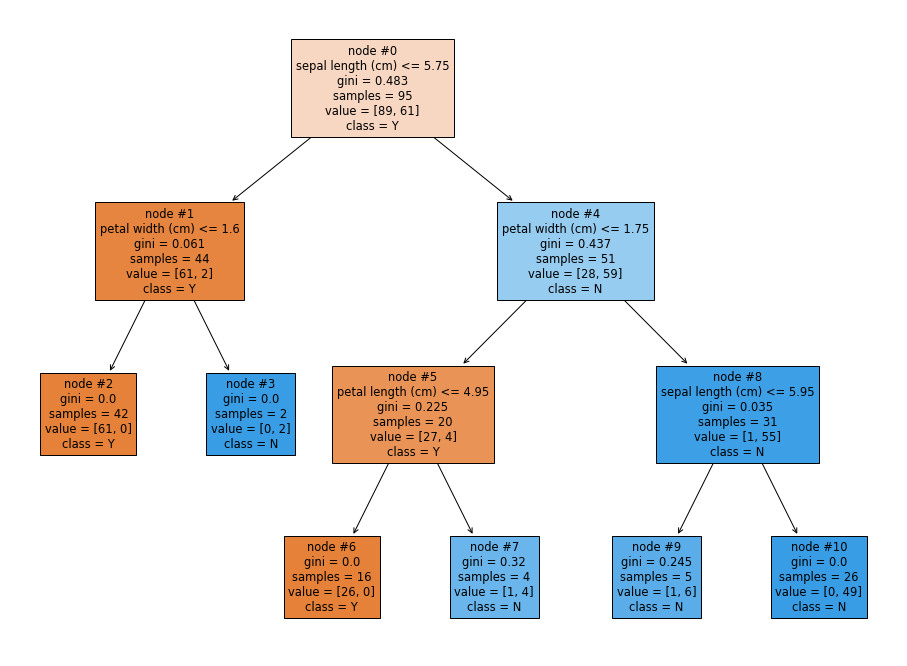

In [6]:
from sklearn import tree
plt.figure(figsize=(16,12))
tree.plot_tree(tree_list[0], filled=True, feature_names=iris['feature_names'], 
               class_names=['Y', 'N'], node_ids=True);

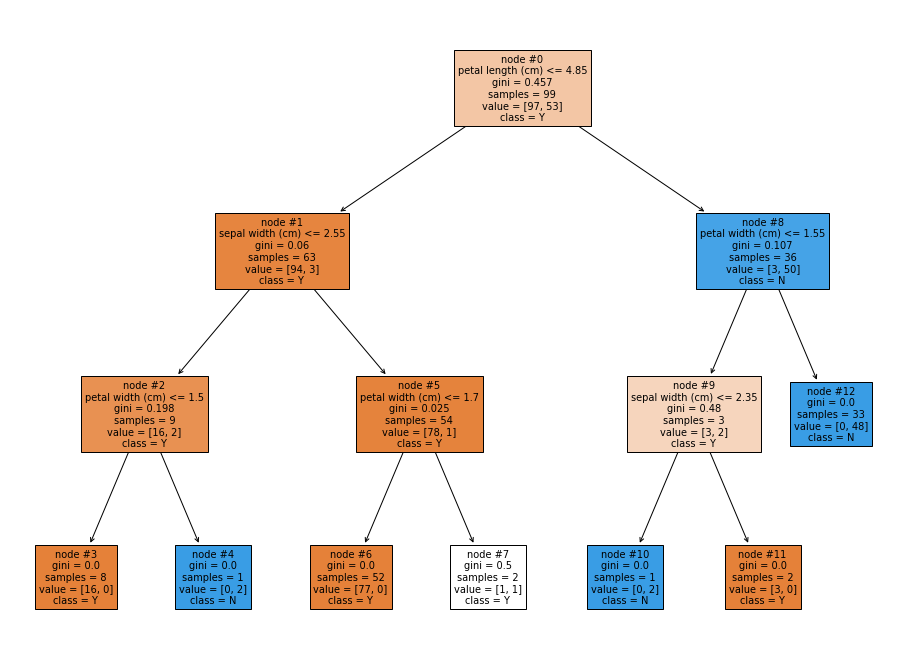

In [7]:
plt.figure(figsize=(16,12))
tree.plot_tree(tree_list[1], filled=True, feature_names=iris['feature_names'], 
               class_names=['Y', 'N'], node_ids=True);

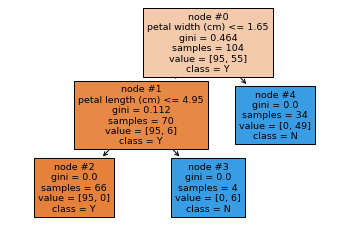

In [8]:
plt.figure(figsize=(6,4))
tree.plot_tree(tree_list[2], filled=True, feature_names=iris['feature_names'], 
               class_names=['Y', 'N'], node_ids=True);

Почнемо з першого дерева та ознаки `Sepal length (cm)`. Ця ознака розташована у двох вузлах: кореневому (#0) та крайньому правому вузлі (#8). Зменшення невизначеності для цих вузлів:

$$\large {RI}_{{SL}_1}^{(1)}=\frac{150}{150}\cdot 0.482578 - \frac{63}{150}\cdot 0.061476 - \frac{87}{150}\cdot 0.436517 = 0.203578$$

$$\large {RI}_{{SL}_2}^{(1)}=\frac{56}{150}\cdot 0.035077 - \frac{7}{150}\cdot 0.244898 - \frac{49}{150}\cdot 0 = 0.001667$$

Примітка: Невизначеність для кожного вузла була перерахована для отримання більшої точності, ніж вказана на рисунку.

Виконуючи ті самі розрахунки, ми отримуємо таке зменшення невизначеностей для ознак `Petal length (cm)` та `Petal width (cm)`:

$$\large {RI}_{PL}^{(1)}=0.035785$$

$$\large {RI}_{{PW}_1}^{(1)}=0.025820$$

$$\large {RI}_{{PW}_2}^{(1)}=0.193633$$

Подамо сумарні значення в таблиці

$$\begin{array}{c|cc}
  \text{Ознака}, j & \text{Сумарне }RI_j^{(1)} & {FI}_j^{(1)}\\ 
  \hline
  SL & 0.205244 & 0.445716\\
  SW & 0.000000 & 0.000000\\
  PL & 0.035785 & 0.077712\\
  PW & 0.219453 & 0.476572\\
  \hline
  \sum & 0.460483
 \end{array}$$
 
 Виконавши аналогічні розрахунки для другого та третього дерева, ми усереднюємо результати за ознаками:

$$\begin{array}{c|ccc|c}
  \text{Ознака}, j & {FI}_j^{(1)}& {FI}_j^{(2)}& {FI}_j^{(3)} & {FI}_j\\ 
  \hline
  SL & 0.445716 & 0.000000 & 0.000000 & 0.148572\\
  SW & 0.000000 & 0.039738 & 0.000000 & 0.013246\\
  PL & 0.077712 & 0.844925 & 0.162016 & 0.361551\\
  PW & 0.476572 & 0.115337 & 0.837984 & 0.476631\\
 \end{array}$$

Давайте порівняємо наш результат із результатами, що зберігаються в атрибуті `feature _importations_`.

In [9]:
print(iris['feature_names'])
print(rfc.feature_importances_)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[0.14857187 0.01324612 0.36155096 0.47663104]


## 4. Практичний приклад

Розглянемо результати анкетування відвідувачів хостелів з сайтів Booking.com і TripAdvisor.com. Ознаки — середні оцінки за різними факторами (перераховані нижче) — персонал, стан кімнат і т.д. Цільовий ознака — рейтинг хостелу на сайті.

In [10]:
from sklearn.ensemble import RandomForestRegressor

Feature ranking:
1. Staff 0.183150 
2. Value for money 0.147704 
3. Shared space condition 0.128188 
4. Extra services 0.116819 
5. Customer Co-creation 0.105748 
6. General conditions & conveniences 0.088730 
7. Shared kitchen condition 0.074776 
8. Check-in and check-out 0.061881 
9. Hostel booking 0.053899 
10. Room condition 0.039105 


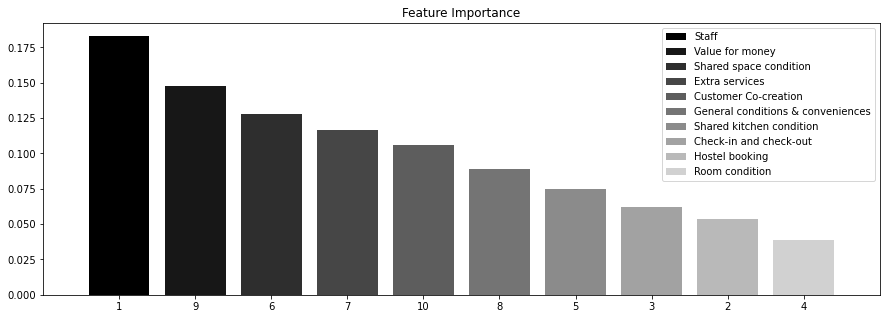

In [11]:
hostel_data = pd.read_csv("../data/hostel_factors.csv")
features = {"f1":u"Staff",
"f2":u"Hostel booking",
"f3":u"Check-in and check-out",
"f4":u"Room condition",
"f5":u"Shared kitchen condition",
"f6":u"Shared space condition",
"f7":u"Extra services",
"f8":u"General conditions & conveniences",
"f9":u"Value for money",
"f10":u"Customer Co-creation"}

forest = RandomForestRegressor(n_estimators=1000, max_features=10,
                                random_state=0)

forest.fit(hostel_data.drop(['hostel', 'rating'], axis=1), 
           hostel_data['rating'])
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Feature Importance")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);

На рисунку вище видно, що люди найбільше звертають увагу на персонал і співвідношення ціна/якість і на основі враження від цих речей пишуть свої відгуки. Проте різниця між цими ознаками і менш впливовими ознаками не надто значна, і викидання якоїсь ознаки призведе до зменшення точності моделі. Але навіть на основі такого аналізу можна дати рекомендації готелям в першу чергу краще готувати персонал і/або поліпшити якість відповідно до заявленої ціни.